## Intro

In [3]:
import torch
import platform

def check_gpu():
    system = platform.system()

    if system == "Darwin":  # macOS
        if torch.backends.mps.is_available():
            print("✅ GPU available: Apple Metal (MPS) is ready for training.")
            device = torch.device("mps")
        else:
            print("❌ No GPU available. Training will run on CPU.")
            device = torch.device("cpu")

    elif torch.cuda.is_available():  # NVIDIA GPU (Windows/Linux)
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
        device = torch.device("cuda")

    else:
        print("❌ No GPU available. Training will run on CPU.")
        device = torch.device("cpu")

    return device

device = check_gpu()
print("Using device:", device)

✅ GPU available: Apple Metal (MPS) is ready for training.
Using device: mps


In [4]:
# !pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

In [5]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
import sys, os

# Go up one folder (to the project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

print("Added to sys.path:", project_root)

Added to sys.path: /Users/reiner/Documents/GitHub/cadenza_2026_submission


## Load Dataset

Because the dataset is not acessible, we load our own data in the same format

In [7]:
from torch.utils.data import DataLoader
from project.dataset.audio_dataset_whisper import get_data_loader
from project.hparams import Hparams

train_loader = get_data_loader(split='train', args=Hparams.data_loader_args)

for batch in train_loader:
    input_features = batch["input_features"]     # [B, 80, T]
    labels = batch["labels"]                     # [B, L]
    metadata = batch["metadata"]                 # list of dicts
    
    # Example: run through model
    # outputs = model(input_features=input_features, labels=labels)
    # loss = outputs.loss

    print("Features:", input_features.shape)
    print("Labels:", labels.shape)
    print("First prompt:", metadata[0]["prompt"])
    break


Features: torch.Size([2, 80, 3000])
Labels: torch.Size([2, 14])
First prompt: i said jack is a metal detector


/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/audio_dataset_whisper.py:24: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.set_audio_backend("soundfile")
/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchaudio/_internal/module_utils.py:71: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  return func(*args, **kwargs)
/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: Us

In [8]:
batch = next(iter(train_loader))
input_features = batch["input_features"]  # shape: [B, 80, T]

mel = input_features[0].numpy()  # take the first sample
print(mel.shape)  # (80, time_frames)



(80, 3000)


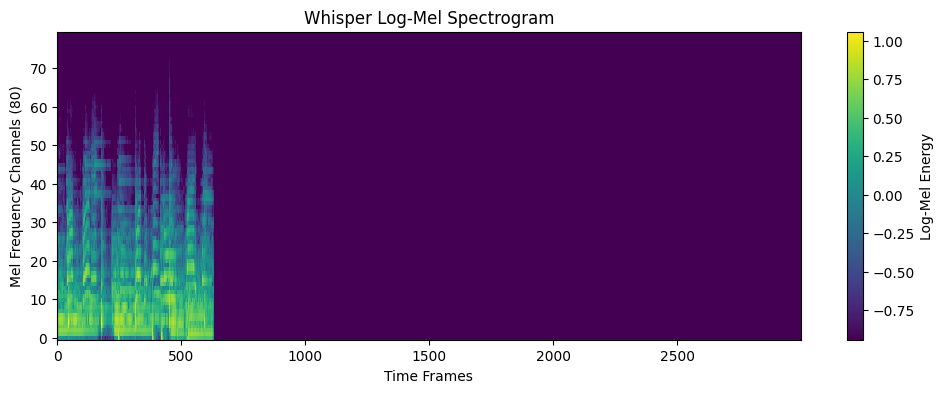

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 4))
plt.imshow(mel, origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar(label="Log-Mel Energy")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Channels (80)")
plt.title("Whisper Log-Mel Spectrogram")
plt.show()


## Optional Visualization

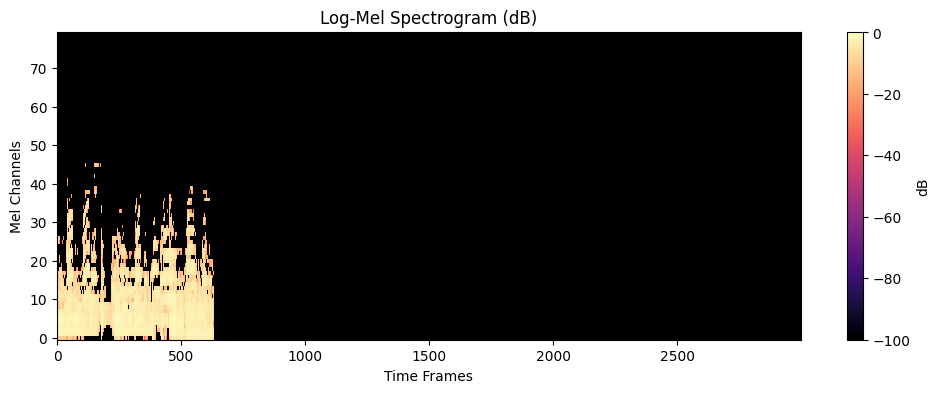

In [10]:
import numpy as np
mel_db = 10 * np.log10(np.maximum(mel, 1e-10))
plt.figure(figsize=(12, 4))
plt.imshow(mel_db, origin="lower", aspect="auto", interpolation="nearest", cmap="magma")
plt.colorbar(label="dB")
plt.xlabel("Time Frames")
plt.ylabel("Mel Channels")
plt.title("Log-Mel Spectrogram (dB)")
plt.show()


In [11]:
labels = batch["labels"]
print("Unique label values:", torch.unique(labels))

Unique label values: tensor([  264,   380,   390,   456,   457,   483,   572,   741,   786,   847,
         1442,  7862,  8440,  9360,  9488, 11314, 16914, 50257, 50258, 50363])


In [12]:
print(batch)

{'input_features': tensor([[[-0.9413, -0.9413, -0.3299,  ..., -0.9413, -0.9413, -0.9413],
         [-0.9413, -0.9413, -0.2188,  ..., -0.9413, -0.9413, -0.9413],
         [-0.9413, -0.9413, -0.1089,  ..., -0.9413, -0.9413, -0.9413],
         ...,
         [-0.9413, -0.9413, -0.9413,  ..., -0.9413, -0.9413, -0.9413],
         [-0.9413, -0.9413, -0.9413,  ..., -0.9413, -0.9413, -0.9413],
         [-0.9413, -0.9413, -0.9413,  ..., -0.9413, -0.9413, -0.9413]],

        [[-1.0462, -1.0462, -0.2020,  ..., -1.0462, -1.0462, -1.0462],
         [-1.0462, -1.0462, -0.2684,  ..., -1.0462, -1.0462, -1.0462],
         [-1.0462, -1.0462, -0.2813,  ..., -1.0462, -1.0462, -1.0462],
         ...,
         [-1.0462, -1.0462, -1.0462,  ..., -1.0462, -1.0462, -1.0462],
         [-1.0462, -1.0462, -1.0462,  ..., -1.0462, -1.0462, -1.0462],
         [-1.0462, -1.0462, -1.0462,  ..., -1.0462, -1.0462, -1.0462]]]), 'labels': tensor([[50258, 50363, 11314,   390,  9488,   457,   456,  7862,   380,   572,
       

In [13]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="English-US", task="transcribe")

In [14]:
decoded = [tokenizer.decode(l, skip_special_tokens=False) for l in labels]
print(decoded)

["<|startoftranscript|><|notimestamps|>sun was burning but there ain't no light<|endoftext|>", '<|startoftranscript|><|notimestamps|>get dirty til the day i get knocked<|endoftext|><|endoftext|>']


## OLD

In [15]:
import json
from project.utils.utils import dump_json

print("First metadata entry:", metadata)

dataset = train_loader.dataset
waveform_dict = dataset[0]  # first sample

waveform = waveform_dict["waveform"]

print('\nfrom train_loader.dataset')
print(waveform_dict["waveform"].shape)
print(waveform_dict['sample_rate'])

# print(waveform_dict["metadata"])


print(dump_json(waveform_dict["metadata"]))


First metadata entry: [{'signal': '391f4f70f29a293ea22b4d3b', 'fma': '004429', 'original_prompt': 'I said Jack is a metal detector', 'prompt': 'i said jack is a metal detector', 'original_response': 'Just like a metal detector', 'response': 'just like a metal detector', 'n_words': 7, 'words_correct': 3, 'correctness': 0.4285714286, 'hearing_loss': 'Mild'}, {'signal': 'cbb180a8c5b9d0da4b8fe811', 'fma': '116211', 'original_prompt': 'French quarter no borders take me back as I am', 'prompt': 'french quarter no borders take me back as i am', 'original_response': 'no quater taking back as I answer', 'response': 'no quarter taking back as i answer', 'n_words': 10, 'words_correct': 4, 'correctness': 0.4, 'hearing_loss': 'Mild'}]


/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


KeyError: 'waveform'

In [ ]:
import soundfile as sf
import IPython.display as ipd

# Convert stereo to mono if needed
# if waveform.ndim > 1 and waveform.shape[0] == 2:
#     waveform = waveform.mean(axis=0)


# # Change this to your actual file path
# audio_path = f"/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data/train/signals/{waveform_dict["signal"]}.flac"

# x, sr = sf.read(audio_path)
# if x.ndim == 2:
#     x = x.mean(axis=1)

# print(f"Loaded audio: {len(x)/sr:.2f} seconds, sample rate: {sr} Hz")

# ▶️ Play the original audio
ipd.Audio(waveform_dict['waveform'], rate=waveform_dict['sample_rate'])


## Prepare Feature Extractor, Tokenizer and Data

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [ ]:
print(dataset[0])

{'waveform': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'sample_rate': 44100, 'metadata': {'signal': 'c221f2084c780e8f212f4697', 'fma': '147301', 'original_prompt': 'cos you better hold on', 'prompt': 'cos you better hold on', 'original_response': '#', 'response': '', 'n_words': 5, 'words_correct': 0, 'correctness': 0.0, 'hearing_loss': 'Moderate', 'tokenized_prompt': [3, 15, 19, 27, 25, 15, 21, 27, 2, 5, 20, 20, 5, 18, 27, 8, 15, 12, 4, 27, 15, 14], 'tokenized_response': []}}


/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [ ]:
def extract_features_from_batch(batch):
    waveform = batch["waveform"]
    sr = batch["sample_rate"]
    
    # Convert to mono if stereo
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Resample 44.1kHz → 16kHz
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)
        sr = 16000

    # Convert to numpy for Whisper extractor
    input_features = feature_extractor(
        waveform.squeeze().numpy(),
        sampling_rate=sr
    ).input_features[0]
    
    return input_features


In [ ]:
# def prepare_dataset(batch):
#     # load and resample audio data from 48 to 16kHz
#     audio = batch["audio"]

#     # compute log-Mel input features from input audio array
#     batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

#     # encode target text to label ids
#     batch["labels"] = tokenizer(batch["sentence"]).input_ids
#     return batch

In [ ]:
# common_voice = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

In [ ]:
# import torchaudio
# from torchaudio.transforms import Resample

In [ ]:
# from datasets import Audio

# common_voice = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
from datasets import Dataset, Audio

import os
os.environ["HF_DATASETS_AUDIO_ALLOW_TORCHCODEC"] = "0"

import json
from pathlib import Path

import datasets

root_dir = Path("/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data")  # adjust
split = "train"

# Load metadata
metadata_path = root_dir / "metadata" / f"{split}_metadata.json"
with open(metadata_path, "r") as f:
    metadata = json.load(f)

# Build list for HF dataset
data = []
for m in metadata:
    audio_path = str(root_dir / split / "signals" / f"{m['signal']}.flac")
    text = m.get("response", "") or m.get("prompt", "")
    data.append({"audio": audio_path, "sentence": text})

dataset = Dataset.from_list(data)
datasets.config.USE_TORCHCODEC = False
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))


In [ ]:
dataset[0]

RuntimeError: Could not load libtorchcodec. Likely causes:
          1. FFmpeg is not properly installed in your environment. We support
             versions 4, 5, 6 and 7.
          2. The PyTorch version (2.8.0) is not compatible with
             this version of TorchCodec. Refer to the version compatibility
             table:
             https://github.com/pytorch/torchcodec?tab=readme-ov-file#installing-torchcodec.
          3. Another runtime dependency; see exceptions below.
        The following exceptions were raised as we tried to load libtorchcodec:
        
[start of libtorchcodec loading traceback]
FFmpeg version 8: dlopen(/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core8.dylib, 0x0006): Library not loaded: @rpath/libavutil.60.dylib
  Referenced from: <74E3964C-5A64-3E6C-B5FB-0D97C42CA105> /Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core8.dylib
  Reason: no LC_RPATH's found
FFmpeg version 7: dlopen(/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core7.dylib, 0x0006): Library not loaded: @rpath/libavutil.59.dylib
  Referenced from: <FA3A9C2C-C7F0-32EA-80CD-C8311F4431DE> /Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core7.dylib
  Reason: no LC_RPATH's found
FFmpeg version 6: dlopen(/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core6.dylib, 0x0006): Library not loaded: @rpath/libavutil.58.dylib
  Referenced from: <31190869-AB3E-379B-ACC5-BCDF5DF127F4> /Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core6.dylib
  Reason: no LC_RPATH's found
FFmpeg version 5: dlopen(/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core5.dylib, 0x0006): Library not loaded: @rpath/libavutil.57.dylib
  Referenced from: <ADD2E0C0-4A46-3588-A8D1-3663B3ABA7FF> /Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core5.dylib
  Reason: no LC_RPATH's found
FFmpeg version 4: dlopen(/Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core4.dylib, 0x0006): Library not loaded: @rpath/libavutil.56.dylib
  Referenced from: <5D9D469F-0637-3DBF-8091-B7B604D63EAE> /Users/reiner/Documents/GitHub/cadenza_2026_submission/venv/lib/python3.12/site-packages/torchcodec/libtorchcodec_core4.dylib
  Reason: no LC_RPATH's found
[end of libtorchcodec loading traceback].

# complete code

## WINDOWS

In [ ]:
import os
import json
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
from dataclasses import dataclass
from typing import Any

from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from peft import (
    prepare_model_for_kbit_training,
    LoraConfig,
    get_peft_model,
)
import evaluate

# ============================================================
# 1. Configuration
# ============================================================
# Better for .py files
# PROJECT_ROOT = Path(__file__).resolve().parent.parent
# DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "project" / "dataset" / "cadenza_data"))

# Better for .ipynb files
DATA_ROOT = Path(r"\\wsl.localhost\Ubuntu\home\reiner\github\cadenza_2026_submission\project\dataset\cadenza_data")

TRAIN_AUDIO_DIR = DATA_ROOT / "train" / "signals"
VALID_AUDIO_DIR = DATA_ROOT / "valid" / "signals"
TRAIN_METADATA_PATH = DATA_ROOT / "metadata" / "train_metadata.json"
VALID_METADATA_PATH = DATA_ROOT / "metadata" / "valid_metadata.json"  # optional

MODEL_NAME = "openai/whisper-small"  # or "openai/whisper-large-v2"
LANGUAGE = "English"
TASK = "transcribe"

BATCH_SIZE = 4
NUM_EPOCHS = 3
LEARNING_RATE = 1e-3
TARGET_SR = 16000

device = "cuda" if torch.cuda.is_available() else "cpu"
    
# Print device here
print("🔍 CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🧠 GPU device:", torch.cuda.get_device_name(0))
    print("🔥 Current device index:", torch.cuda.current_device())
else:
    print("⚠️ Using CPU — training will be very slow")

# ============================================================
# 2. Dataset Definition
# ============================================================
class AudioPromptDataset(Dataset):
    def __init__(self, metadata_path, audio_dir, processor, target_sr=16000):
        with open(metadata_path, "r") as f:
            data = json.load(f)
        # handle nested list like [[{...}]]
        self.metadata = data[0] if isinstance(data, list) and isinstance(data[0], list) else data
        self.audio_dir = Path(audio_dir)
        self.processor = processor
        self.target_sr = target_sr

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        entry = self.metadata[idx]
        signal_id = entry["signal"]
        prompt = entry.get("prompt") or entry.get("original_prompt", "")

        audio_path = self.audio_dir / f"{signal_id}.flac"
        waveform, sr = torchaudio.load(audio_path)

        # convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # resample to target_sr
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, self.target_sr)

        # extract input features
        input_features = self.processor.feature_extractor(
            waveform.squeeze().numpy(), sampling_rate=self.target_sr
        ).input_features[0]

        # tokenize the text
        labels = self.processor.tokenizer(prompt, return_tensors="pt").input_ids.squeeze(0)

        return {"input_features": input_features, "labels": labels}


# ============================================================
# 3. Collator Function
# ============================================================
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features):
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # remove duplicate BOS if exists
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch


# ============================================================
# 4. Load Processor and Dataset
# ============================================================
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)

train_dataset = AudioPromptDataset(TRAIN_METADATA_PATH, TRAIN_AUDIO_DIR, processor, TARGET_SR)
valid_dataset = (
    AudioPromptDataset(VALID_METADATA_PATH, VALID_AUDIO_DIR, processor, TARGET_SR)
    if VALID_METADATA_PATH.exists()
    else None
)
collator = DataCollatorSpeechSeq2SeqWithPadding(processor)

# ============================================================
# 5. Load Whisper Model (16-bit) and Prepare for LoRA
# ============================================================
model = WhisperForConditionalGeneration.from_pretrained(
    MODEL_NAME, 
    # torch_dtype=torch.float8_e4m3fn if torch.cuda.is_available() else torch.float8_e4m3fnuz,
    dtype=torch.float16,
    device_map="auto"
)

model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

model = prepare_model_for_kbit_training(model)

# LoRA setup
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(model, lora_config)

print("Trainable parameters:")
model.print_trainable_parameters()

# ============================================================
# 6. Evaluation Metric (WER)
# ============================================================
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}


# ============================================================
# 7. Trainer Setup
# ============================================================
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_lora_results",
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=LEARNING_RATE,
    warmup_steps=50,
    num_train_epochs=NUM_EPOCHS,
    eval_strategy="epoch" if valid_dataset else "no",
    save_strategy="epoch",
    logging_steps=10,
    logging_dir="./logs",
    fp16=True,
    remove_unused_columns=False,
    label_names=["labels"],
    report_to="none",
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset if valid_dataset else None,
    data_collator=collator,
    tokenizer=processor,
    compute_metrics=compute_metrics if valid_dataset else None,
)

model.config.use_cache = False  # disable for training

# ============================================================
# 8. Train and Save
# ============================================================
from types import MethodType

def safe_forward(self, *args, **kwargs):
    # Drop 'input_ids' if it appears (Trainer sometimes injects it)
    kwargs.pop("input_ids", None)
    return self.base_model.forward(*args, **kwargs)

# Attach to PEFT model
model.forward = MethodType(safe_forward, model)

trainer.train()

SAVE_DIR = "./whisper_lora_finetuned"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
processor.save_pretrained(SAVE_DIR)
print(f"✅ Training complete! Model saved to: {SAVE_DIR}")

ModuleNotFoundError: No module named 'transformers'

In [1]:
# --- Sanity check ---
first_batch = next(iter(DataLoader(train_dataset, batch_size=2, collate_fn=collator)))
print("Batch keys:", first_batch.keys())
for k, v in first_batch.items():
    print(f"{k}: {v.shape if torch.is_tensor(v) else type(v)}")


NameError: name 'DataLoader' is not defined

## MAC

In [2]:
import os
import json
from pathlib import Path
import torch
from torch.utils.data import Dataset
import torchaudio
from dataclasses import dataclass
from typing import Any

from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
from peft import LoraConfig, get_peft_model
import evaluate

# ============================================================
# 1. Configuration
# ============================================================
DATA_ROOT = Path("/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data")
TRAIN_AUDIO_DIR = DATA_ROOT / "train" / "signals"
VALID_AUDIO_DIR = DATA_ROOT / "valid" / "signals"
TRAIN_METADATA_PATH = DATA_ROOT / "metadata" / "train_metadata.json"
VALID_METADATA_PATH = DATA_ROOT / "metadata" / "valid_metadata.json"  # optional

MODEL_NAME = "openai/whisper-small"
LANGUAGE = "English"
TASK = "transcribe"

BATCH_SIZE = 4
NUM_EPOCHS = 3
LEARNING_RATE = 1e-3
TARGET_SR = 16000

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# 2. Dataset
# ============================================================
class AudioPromptDataset(Dataset):
    def __init__(self, metadata_path, audio_dir, processor, target_sr=16000):
        with open(metadata_path, "r") as f:
            data = json.load(f)
        self.metadata = data[0] if isinstance(data, list) and isinstance(data[0], list) else data
        self.audio_dir = Path(audio_dir)
        self.processor = processor
        self.target_sr = target_sr

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        entry = self.metadata[idx]
        signal_id = entry["signal"]
        prompt = entry.get("prompt") or entry.get("original_prompt", "")

        audio_path = self.audio_dir / f"{signal_id}.flac"
        waveform, sr = torchaudio.load(audio_path)

        # Convert stereo → mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Resample
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, self.target_sr)

        input_features = self.processor.feature_extractor(
            waveform.squeeze().numpy(), sampling_rate=self.target_sr
        ).input_features[0]

        labels = self.processor.tokenizer(prompt, return_tensors="pt").input_ids.squeeze(0)
        return {"input_features": input_features, "labels": labels}

# ============================================================
# 3. Collator
# ============================================================
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features):
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

# ============================================================
# 4. Load Processor & Datasets
# ============================================================
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)

train_dataset = AudioPromptDataset(TRAIN_METADATA_PATH, TRAIN_AUDIO_DIR, processor, TARGET_SR)
valid_dataset = AudioPromptDataset(VALID_METADATA_PATH, VALID_AUDIO_DIR, processor, TARGET_SR) if VALID_METADATA_PATH.exists() else None
collator = DataCollatorSpeechSeq2SeqWithPadding(processor)

# ============================================================
# 5. Model + LoRA
# ============================================================
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(device)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

# Apply LoRA adapters
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(model, lora_config)

# Fix: wrapper to remap input_ids → input_features
class WhisperPeftWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_features=None, input_ids=None, labels=None, **kwargs):
        if input_features is None and input_ids is not None:
            input_features = input_ids
        return self.model(input_features=input_features, labels=labels, **kwargs)

model = WhisperPeftWrapper(model)

print("✅ LoRA applied successfully")
model.model.print_trainable_parameters()

# ============================================================
# 6. Metrics
# ============================================================
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# ============================================================
# 7. Trainer
# ============================================================
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_lora_results",
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=LEARNING_RATE,
    warmup_steps=50,
    num_train_epochs=NUM_EPOCHS,
    eval_strategy="epoch" if valid_dataset else "no",
    save_strategy="epoch",
    logging_steps=10,
    remove_unused_columns=False,
    label_names=["labels"],
    fp16=torch.cuda.is_available(),  # no fp16 on MPS
    report_to="none",
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset if valid_dataset else None,
    data_collator=collator,
    processing_class=processor,
    compute_metrics=compute_metrics if valid_dataset else None,
)

model.model.config.use_cache = False

# ============================================================
# 8. Train & Save
# ============================================================
trainer.train()

SAVE_DIR = "./whisper_lora_finetuned"
os.makedirs(SAVE_DIR, exist_ok=True)
model.model.save_pretrained(SAVE_DIR)
processor.save_pretrained(SAVE_DIR)
print(f"✅ Training complete! Model saved to: {SAVE_DIR}")


✅ LoRA applied successfully
trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TypeError: WhisperForConditionalGeneration.forward() got an unexpected keyword argument 'input_ids'

In [6]:
import transformers
print(transformers.__version__)


4.57.1


In [7]:
import transformers
from transformers import Seq2SeqTrainingArguments
print(transformers.__version__)
print(Seq2SeqTrainingArguments.__module__)
print(Seq2SeqTrainingArguments.__init__.__code__.co_varnames)


4.57.1
transformers.training_args_seq2seq
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'bf16', 'fp16', 'fp16_opt_lev

In [5]:
import os
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Any

import torch
from torch.utils.data import Dataset
import torchaudio

from transformers import (
    WhisperFeatureExtractor,
    WhisperTokenizer,
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
from peft import LoraConfig, get_peft_model
import evaluate

# ============================================================
# 1) Config
# ============================================================
DATA_ROOT = Path("/Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data")
TRAIN_AUDIO_DIR = DATA_ROOT / "train" / "signals"
VALID_AUDIO_DIR = DATA_ROOT / "valid" / "signals"
TRAIN_METADATA_PATH = DATA_ROOT / "metadata" / "train_metadata.json"
VALID_METADATA_PATH = DATA_ROOT / "metadata" / "valid_metadata.json"  # optional

MODEL_NAME = "openai/whisper-small"  # change to large-v2 if you have VRAM/CPU
LANGUAGE = "English"
TASK = "transcribe"

BATCH_SIZE = 4
NUM_EPOCHS = 3
LEARNING_RATE = 1e-3
TARGET_SR = 16000

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 2) Dataset
# ============================================================
class AudioPromptDataset(Dataset):
    def __init__(self, metadata_path, audio_dir, processor, target_sr=16000):
        with open(metadata_path, "r") as f:
            data = json.load(f)
        # handle nested [[{...}]]
        self.metadata = data[0] if isinstance(data, list) and isinstance(data[0], list) else data
        self.audio_dir = Path(audio_dir)
        self.processor = processor
        self.target_sr = target_sr

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        entry = self.metadata[idx]
        signal_id = entry["signal"]
        prompt = entry.get("prompt") or entry.get("original_prompt", "")

        audio_path = self.audio_dir / f"{signal_id}.flac"
        waveform, sr = torchaudio.load(audio_path)

        # mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        # resample
        if sr != self.target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, self.target_sr)

        # Whisper features (log-mel)
        input_features = self.processor.feature_extractor(
            waveform.squeeze().numpy(), sampling_rate=self.target_sr
        ).input_features[0]

        # Decoder labels
        labels = self.processor.tokenizer(prompt, return_tensors="pt").input_ids.squeeze(0)

        # IMPORTANT: return "input_features" (NOT input_ids)
        return {"input_features": input_features, "labels": labels}

# ============================================================
# 3) Collator
# ============================================================
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    def __call__(self, features):
        # pad input_features
        input_features = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # pad labels; mask pad to -100
        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if BOS already present everywhere, drop it to avoid double-BOS
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

# ============================================================
# 4) Processor & datasets
# ============================================================
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language=LANGUAGE, task=TASK)

train_dataset = AudioPromptDataset(TRAIN_METADATA_PATH, TRAIN_AUDIO_DIR, processor, TARGET_SR)
valid_dataset = AudioPromptDataset(VALID_METADATA_PATH, VALID_AUDIO_DIR, processor, TARGET_SR) \
    if VALID_METADATA_PATH.exists() else None

collator = DataCollatorSpeechSeq2SeqWithPadding(processor)

# ============================================================
# 5) Model + LoRA (no bitsandbytes)
# ============================================================
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to(device)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(model, lora_cfg)

print("✅ LoRA applied. Trainable parameters:")
model.print_trainable_parameters()

# ============================================================
# 6) Metrics
# ============================================================
wer_metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    return {"wer": 100 * wer_metric.compute(predictions=pred_str, references=label_str)}

# ============================================================
# 7) Custom Trainer to remap keys (input_ids -> input_features)
# ============================================================
class WhisperSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Trainer sometimes uses 'input_ids' key by default; Whisper expects 'input_features'
        if "input_features" not in inputs and "input_ids" in inputs:
            inputs["input_features"] = inputs.pop("input_ids")
        return super().compute_loss(model, inputs, return_outputs=return_outputs, num_items_in_batch=num_items_in_batch)

# ============================================================
# 8) Training args & Trainer
# ============================================================
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper_lora_results",
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=1,
    learning_rate=LEARNING_RATE,
    warmup_steps=50,
    num_train_epochs=NUM_EPOCHS,
    eval_strategy="epoch" if valid_dataset else "no",  # use 'eval_strategy' since that's working in your env
    save_strategy="epoch",
    logging_steps=10,
    remove_unused_columns=False,     # DO NOT drop unknown columns; we keep input_features
    label_names=["labels"],          # ensure labels passed through
    fp16=torch.cuda.is_available(),  # MPS doesn't support fp16
    report_to="none",
)

trainer = WhisperSeq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset if valid_dataset else None,
    data_collator=collator,
    processing_class=processor,   # unified processor (feature_extractor + tokenizer)
    compute_metrics=compute_metrics if valid_dataset else None,
)

model.config.use_cache = False

# ============================================================
# 9) Train & Save
# ============================================================
trainer.train()

SAVE_DIR = "./whisper_lora_finetuned"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
processor.save_pretrained(SAVE_DIR)
print(f"✅ Training complete! Model saved to: {SAVE_DIR}")


✅ LoRA applied. Trainable parameters:
trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TypeError: WhisperForConditionalGeneration.forward() got an unexpected keyword argument 'input_ids'